#### Surface fluxes from ERA-5
In this notebook, we are going to read in some ERA-5 Reanalysis fluxes, plot them, and then try to calculate them ourselves using the formulas from the textbook. 
More information about ERA-5 can be found [here](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5).

The data is available over the Nordic Seas, from 50˚N to 85˚N, and from 25˚W to 25˚E, and is the monthly average of May 2020. The spatial resolution is 0.25˚ x 0.25˚, which corresponds to about 27 km.

The data with all the variables is stored in a `netCDF`-file. Let's read in the contents of this file, using the `Dataset` function from the `netCDF4`-package:

In [75]:
from netCDF4 import Dataset

era_file = './ERA5_fluxes_202005.nc'
era_data = Dataset(era_file)
print(era_data.variables)

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (201,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (141,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of -2147483647 used, 'si10': <class 'netCDF4._netCDF4.Variable'>
int16 si10(time, latitude, longitude)
    scale_factor: 0.00013505540624570827
    add_offset: 5.041132454463168
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: 10 metre wind speed
unlimited dimensions: 
cur

We notice that there are variables containing the different fluxes:
* `slhf`: Surface latent heat flux
* `sshf`: Surface sensible heat flux
* `str` : Surface net thermal radiation (Longwave radiation)
* `ssr` : Surface net solar radiation (Shortwave radiation)

We also have the information that the values for the fluxes are in J m$^{-2}$. 

There are also other variables, which we can use to calculate above listed fluxes ourselves, and compare them to the actual output:
* `sst`  : Sea surface temperature
* `tisr` : TOA (Top Of Atmosphere) incident solar radiation
* `tcc`  : Total cloud cover
* `si10` : 10 metre wind speed
* `fal`  : Forecast albedo
* `d2m`  : 2 metre dewpoint temperature
* `t2m`  : 2 metre temperature

Let's start then by plotting the four surface heat fluxes from ERA-5. For that, we are going to use the `cartopy` and `matplotlib` packages.

/Users/jakobdorr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/jakobdorr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


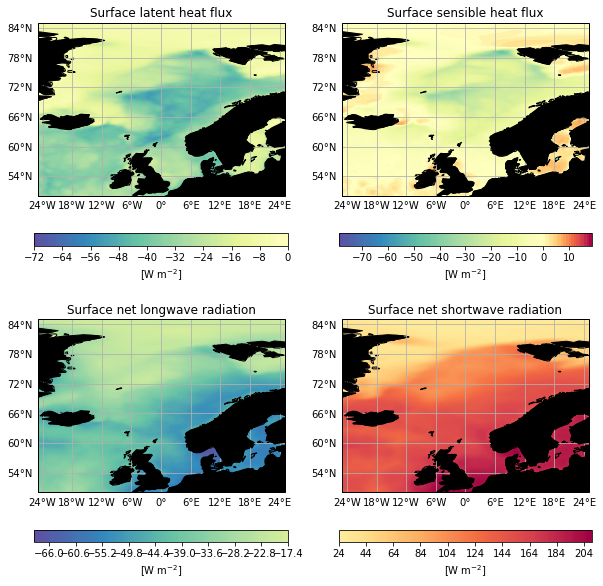

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# cartopy packages
from cartopy import crs as ccrs
import cartopy.feature as cfeatures
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# package to center a colormap around 0
from matplotlib.colors import DivergingNorm

# We will create a map plot with 4 subplots, each showing one flux. We will go through the four
# variables with a loop.
variables = ['slhf','sshf','str','ssr']
# Let's also create a dictionary with the long names of the variables
variable_names = {'slhf': 'Surface latent heat flux', 'sshf': 'Surface sensible heat flux',
                 'str': 'Surface net longwave radiation', 'ssr': 'Surface net shortwave radiation'}

# For plotting, we need the longitude and latitude
lon = era_data.variables['longitude'][:]
lat = era_data.variables['latitude'][:]

# Create a meshgrid out of lon and lat
lon,lat = np.meshgrid(lon,lat)

# Because the fluxes are in J/m**2, let's convert them to W/m**2, by dividing them by
# the amount of seconds in May 2020 (remember W = J/s)
sec_per_month = 31*60*60

# open the figure
fig = plt.figure(figsize=(10,10))
for i,var in enumerate(variables): # loop over variables
    # read the data from the file
    var_data = era_data.variables[var][0,:,:] / sec_per_month
    
    # add a new subplot to the figure, and set the correct spatial extent
    ax = fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.set_extent([-25,25,50,85])

    # plot the data on the map
    im = ax.contourf(lon,lat,var_data,cmap='Spectral_r',levels=100,transform=ccrs.PlateCarree(),
                    norm = DivergingNorm(0))
    
    # add some gridlines, land masses, coastlines and a title
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.add_feature(cfeatures.LAND,zorder=200,color='k')
    ax.coastlines(resolution='50m')
    ax.set_title(variable_names[var])
    
    
    # add a colorbar
    plt.colorbar(im,orientation='horizontal',label='[W m$^{-2}$]')
    
    
plt.tight_layout()